This notebook explores the related topics to veganism in our dataset.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

# Supresses warnings
pd.options.mode.chained_assignment = None
sns.set_theme(style = "white")

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# nltk
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import pyLDAvis.gensim_models
from gensim.models.phrases import Phrases
from gensim import corpora, models

from flair.models import SequenceTagger, TextClassifier
from flair.data import Sentence
from flair.embeddings import WordEmbeddings
from flair.tokenization import SegtokSentenceSplitter

# custom function
from functions import *

nltk.download('stopwords')
nltk.download('punct')
nltk.download('brown')

# dir paths
DATA_DIR = '../data'
IMG_DIR = '../img'
RAW_DATA_DIR = "../raw_data/"

/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package stopwords to /home/romain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading punct: Package 'punct' not found in index
[nltk_data] Downloading package brown to /home/romain/nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Load the data

We load our dataset and preprocess using our main pipeline.

In [4]:
df = pd.read_json(f'{DATA_DIR}/quotebank_attr_2015-2020.json.bz2', compression='bz2')
preprocess_dataframe(df)
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_qid,gender,nationality,date_of_birth,ethnic_group,occupation,party,academic_degree,domains
0,2015-10-05-010038,At Neath Food Festival with a vegetarian platt...,Bethan Jenkins,[Q4897688],2015-10-05 05:00:00,1,"[[Bethan Jenkins, 0.8565], [None, 0.1435]]",[http://www.southwales-eveningpost.co.uk/Town-...,E,Q4897688,None,None,None,None,None,None,None,[southwales-eveningpost.co.uk]
1,2015-11-28-006688,"But if I had to choose my favourite recipe, it...",Trish Deseine,[Q7843986],2015-11-28 00:00:00,1,"[[Trish Deseine, 0.7664], [None, 0.1125], [Kei...",[http://www.irishexaminer.com/lifestyle/featur...,E,Q7843986,None,None,None,None,None,None,None,[irishexaminer.com]
2,2015-11-10-015422,"Children are learning about responsibility, te...",David Price,"[Q1176177, Q16063598, Q20804677, Q20973688, Q3...",2015-11-10 19:30:41,1,"[[David Price, 0.7849], [None, 0.2151]]",[http://news.ifas.ufl.edu/2015/11/ufifas-bok-t...,E,None,None,None,None,None,None,None,None,[ufl.edu]
3,2015-01-16-054273,Once we have added all the vegetables and stoc...,NaN,[],2015-01-16 11:40:11,4,"[[None, 0.6778], [Catherine O'Neill, 0.3222]]",[http://www.bromsgrovestandard.co.uk/2015/01/1...,E,None,None,None,None,None,None,None,None,"[bromsgrovestandard.co.uk, bromsgrovestandard...."
4,2015-02-20-089622,vegans in a steakhouse.,Jim Gaffigan,[Q2093638],2015-02-20 00:05:44,1,"[[Jim Gaffigan, 0.7894], [None, 0.2106]]",[http://unfspinnaker.com/expect-jim-gaffigans-...,E,Q2093638,[male],[United States of America],[+1966-07-07T00:00:00Z],None,"[screenwriter, film producer, television actor...",None,None,[unfspinnaker.com]


# Topic modelling

The goal is here to identify the main topics related to our filtered quotes.

In [5]:
# Load the trained pipeline
nlp = spacy.load('en_core_web_md')  # en_core_web_sm, en_core_web_lg

# Select the quotations
quotations = df['quotation']
print(f"{len(quotations)} quotations loaded.")

66584 quotations loaded.


Our dataset is to large (66k quotations) to be handled directly. That's why we'll use the quotations as chunks.

We'll also add the words we used as filter to our stop-words list.

In [6]:
STOP_WORDS.update(['vegan', 'vegetarian', 'veget', 'plant-based', 'like', 'want', 'lot', 'know'])
print(f"{len(STOP_WORDS)} stopwords.")

334 stopwords.


In [7]:
docs = []  # 1 doc = 1 quotation

for doc in nlp.pipe(quotations, n_process=12, batch_size=50):

    ents = doc.ents

    # Lemmatize, remove stopwords and non-word tokens
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove stopwords and short words
    doc = [token for token in doc if token not in STOP_WORDS and len(token) > 2]

    # Add the multiple words entities
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    docs.append(doc)

Next cell is an example of a quotation, and the document we get.

In [8]:
print(f"Input  : {quotations[1]}")
print(f"Output : {docs[1]}")

Input  : But if I had to choose my favourite recipe, it's the epic Beef Bourguignon with its `roughly chopped' vegetables, one large glass of brandy and `one small calf's foot. (Optional but preferable!)' .
Output : ['choose', 'favourite', 'recipe', 'epic', 'Beef', 'Bourguignon', 'roughly', 'chop', 'vegetable', 'large', 'glass', 'brandy', 'small', 'calf', 'foot', 'optional', 'preferable', 'Beef Bourguignon']


Now, let's add bigrams to the docs.

In [9]:
bigram = Phrases(docs, min_count=15)

all_bigrams = set()
for i in range(len(docs)):
    for token in bigram[docs[i]]:
        if '_' in token:
            docs[i].append(token)
            all_bigrams.add(token)

print(f"{len(all_bigrams)} different bigrams found.")

747 different bigrams found.


We'll now use Gensim to do the topic modeling.

In [10]:
max_freq = 0.5  # Remove words with frequency above
min_wordcount = 4  # Remove words with less occurences
num_topics = 5  # Number of topics we want to extract

dictionary = corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

corpus = [dictionary.doc2bow(doc) for doc in docs]

model = models.LdaMulticore(
    corpus=corpus,
    num_topics=num_topics,
    id2word=dictionary,
    passes=15,
    workers=12,
    random_state=20,
)

print(f"{model.num_topics} topics found:")
for i in range(model.num_topics):
    terms = model.show_topic(i, 10)
    print(f"{i+1} - " + " ".join([x[0] for x in terms]))

5 topics found:
1 - vegetation vegetable fruit area year grow fruit_vegetable farmer water fire
2 - vegetable day people year eat food come free option time
3 - plant base plant_base food eat product meat people think vegetable
4 - vegetable fruit fruit_vegetable fresh eat food meat grow good cook
5 - diet vegetable food eat fruit base plant healthy meat plant_base


Finally, we can plot these topics using pyLDAvis.

In [11]:
data = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

We can identify several topics using lambda arount 0.5, such as animal protection, diets, community related, environment... Let's label them.

**TODO**

In [12]:
topic_labels = ["Environment", "Diet", "Ethics", "Health", "Lifestyle"]

In [13]:
sent_to_cluster = list()
for n, doc in enumerate(corpus):
    if doc:
        cluster = max(model[doc], key=lambda x: x[1])
        sent_to_cluster.append(topic_labels[cluster[0]])
    else:
        sent_to_cluster.append(None)

df['topic'] = sent_to_cluster

In [14]:
quotations_by_topic = df['topic'].value_counts()
quotations_by_topic

Health         16979
Environment    16220
Ethics         13010
Diet           10599
Lifestyle       9584
Name: topic, dtype: int64

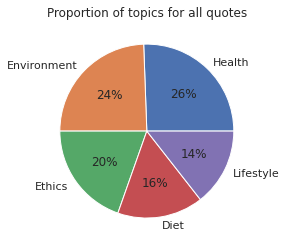

In [15]:
plt.pie(quotations_by_topic.values, labels=quotations_by_topic.index, autopct='%1.0f%%')
plt.title('Proportion of topics for all quotes')
plt.show()

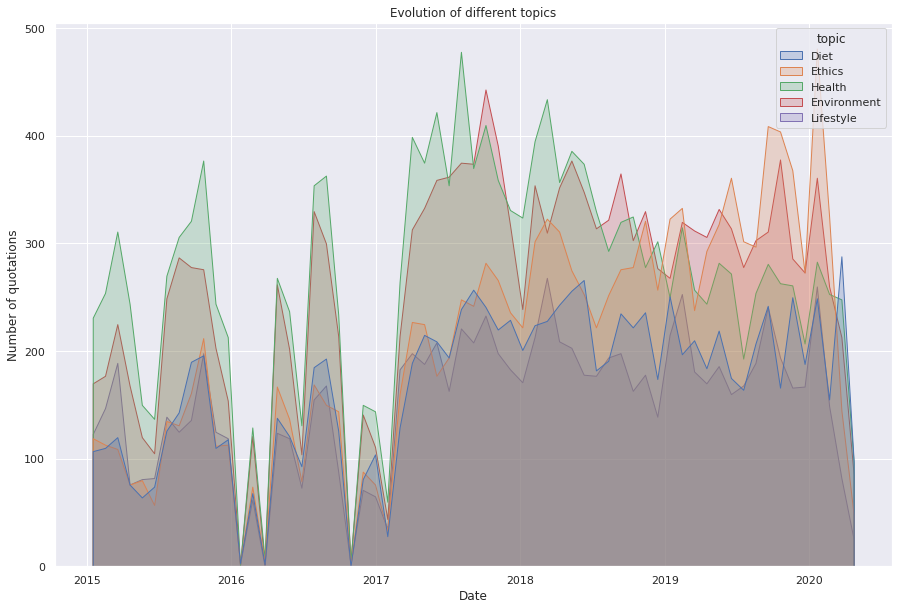

In [16]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15, 10))

ax = sns.histplot(data=df, x=df.date, hue='topic', element='poly', binwidth=31)

title = ax.set_title('Evolution of different topics')
xlabel = ax.set_xlabel('Date')
ylabel = ax.set_ylabel('Number of quotations')

We can see that
- Health and Envionment are becoming less popular
- Ethics is becoming way more popular

# Tagging

In [ ]:
# Load NER
tagger = SequenceTagger.load('ner')
splitter = SegtokSentenceSplitter()

2021-12-16 17:20:38,543 --------------------------------------------------------------------------------
2021-12-16 17:20:38,544 The model key 'ner' now maps to 'https://huggingface.co/flair/ner-english' on the HuggingFace ModelHub
2021-12-16 17:20:38,544  - The most current version of the model is automatically downloaded from there.
2021-12-16 17:20:38,545  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner/en-ner-conll03-v0.4.pt)
2021-12-16 17:20:38,545 --------------------------------------------------------------------------------
2021-12-16 17:20:39,106 loading file /home/romain/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4


In [ ]:
full_text = '\n'.join(df['quotation'])
sentences = splitter.split(full_text)
tagger.predict(sentences)

In [ ]:
spans = [el for sublist in list(map(lambda s: s.get_spans('ner'), sentences)) for el in sublist]
spans_df = pd.DataFrame([{
    'text': s.text,
    'tag': s.tag,
    'score': s.score
} for s in spans])
spans_df.head()

,text,tag,score
0,Neath Food Festival,MISC,0.737163
1,Beef Bourguignon,MISC,0.918579
2,Guinness,MISC,0.451396
3,Patti,PER,0.999696
4,California,LOC,0.999597


In [ ]:
org_spans = spans_df[spans_df['tag'] == 'ORG']

print(f"Most cited organizations (total = {len(org_spans)}):")
org_spans['text'].value_counts()[:10]

Most cited organizations (total = 9339):


PETA           231
McDonald 's     79
EU              69
USDA            59
FDA             59
Congress        57
BJP             51
Labor           37
PG & E          32
Whole Foods     29
Name: text, dtype: int64